In [35]:
import os
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.io import ascii
from astropy.table import Table, join, hstack, vstack
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from astropy.io import fits
from thejoker.data import RVData

import pystan

In [36]:
os.makedirs('calibrate-visit-err', exist_ok=True)

In [37]:
sm = pystan.StanModel('visit-err.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f025c2285e2ea9e6177ef1ff68c8a615 NOW.


In [3]:
allstar = fits.getdata('../data/allStarLite-r12-l33.fits')

In [4]:
allstar_c = coord.SkyCoord(allstar['RA'], allstar['DEC'], unit=u.deg)

In [5]:
allvisit = fits.getdata('../data/allVisit-r12-l33.fits')

## Load exoplanet validation sample:

In [8]:
exop = Table.read('../data/exoplanets_notbinaries.votable')
total_pm = np.sqrt(exop['gaia_pmra']**2 + exop['gaia_pmdec']**2)
slow_exo_mask = ((15*total_pm * u.mas).to(u.arcsec) < 5*u.arcsec)
exop = exop[slow_exo_mask]

In [9]:
exo_c = coord.SkyCoord(ra=exop['ra'], dec=exop['dec'])

In [10]:
idx, sep, _ = exo_c.match_to_catalog_sky(allstar_c)

sub_exop = exop[sep < 8*u.arcsec]['pl_hostname', 'pl_rvamp', 'pl_rvamperr1', 'pl_rvamperr2', 
                                  'hd_name', 'hip_name', 'st_j', 'st_h', 'pl_orbper', 'pl_bmassj']
apogee_exo = hstack((Table(allstar[idx[sep < 8*u.arcsec]]), sub_exop))
hmask = (np.abs(apogee_exo['H'] - apogee_exo['st_h']) < 1e-2)
apogee_exo = apogee_exo[hmask & (apogee_exo['NVISITS'] >= 4) & (apogee_exo['pl_rvamp'] < 50.)]
len(apogee_exo)

13

## Load Gaia RV standards validation sample:

In [14]:
rvs = Table.read(path.expanduser('~/data/GaiaDR2/gaia_dr2_rvs_standards.fit'))
rvs['APOGEE_ID'] = ['2M'+x[6:] for x in rvs['_2MASS']]
rvs = rvs[(rvs['e_RV'] < 0.05) & (rvs['s_RV'] < 0.05)]

In [15]:
mask = np.isin(allstar['APOGEE_ID'], rvs['APOGEE_ID'])

In [16]:
sub_allstar = Table(allstar[mask])

In [17]:
join_tbl = join(sub_allstar, rvs, keys='APOGEE_ID')
join_tbl = join_tbl[join_tbl['NVISITS'] >= 4]
len(join_tbl)

21

---

## Combine the two validation samples:

In [21]:
valid_tbl = vstack((join_tbl, apogee_exo))

In [22]:
visit_mask = np.isin(allvisit['APOGEE_ID'], valid_tbl['APOGEE_ID'])
visits = allvisit[visit_mask]

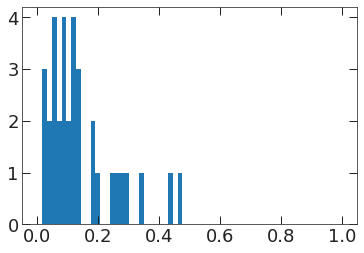

In [23]:
plt.hist(valid_tbl['VSCATTER'], bins=np.linspace(0, 1, 64));

In [24]:
_, all_nvisits, idx = np.unique(visits['APOGEE_ID'], 
                                return_counts=True, return_index=True)

In [25]:
apogee_ids = np.unique(valid_tbl['APOGEE_ID'])
n_stars = len(apogee_ids)
print(n_stars)

all_nvisits = []
rv = []
rv_var = []
rv_snr = []
mean_rv = []
for id_ in apogee_ids:
    this_visits = visits[(visits['APOGEE_ID'] == id_) & np.isfinite(visits['VHELIO'])]
    all_nvisits.append(len(this_visits))
    
    rv.append(this_visits['VHELIO'])
    rv_var.append(this_visits['VRELERR'] ** 2)
    rv_snr.append(this_visits['SNR'])
    mean_rv.append(np.median(this_visits['VHELIO']))
    
rv = np.concatenate(rv)
rv_var = np.concatenate(rv_var)
rv_snr = np.concatenate(rv_snr)

32


In [26]:
data = dict()

data['n_stars'] = n_stars
data['n_visits'] = all_nvisits
data['total_n_visits'] = np.sum(all_nvisits)

data['rv'] = rv
data['rv_var'] = rv_var
data['rv_snr'] = rv_snr

In [27]:
init = dict()

init['mean_rv'] = mean_rv
init['a'] = 1.
init['b'] = -0.5
init['lns'] = -2.

In [28]:
fit = sm.optimizing(data=data, init=init, iter=1024)

In [29]:
fit

OrderedDict([('mean_rv',
              array([ 26.40000558,  45.16139509,  82.64278231,  63.10032531,
                      34.03201785,  33.92539292,  34.00429639,  33.84819727,
                      34.4506301 ,   0.47704048,  -5.48910875,  -1.88916743,
                      -8.7583287 , -32.67383858, -18.03606761, -77.15857533,
                     -11.53584388, -30.58292024, -31.21949975,  -8.17614106,
                     -39.87162985, -70.53214428, -21.67954085, -12.27072421,
                     -28.14049727,   8.10912103, -60.90907654,  27.68220374,
                     -15.91760916, -18.41242861, -25.83667869,   4.30703212])),
             ('a', array(94650.92442511)),
             ('b', array(-4.96112712)),
             ('lns', array(-1.76836891)),
             ('s', array(0.17061104))])

In [41]:
def get_inflation_factor(fit, snr):
    # return fit['a'] + fit['b'] * snr + fit['c'] * snr**2
    # return fit['a'] * snr**fit['b']
    return fit['a'] * snr**fit['b'] + fit['c'] * snr**fit['d']

def get_new_err(fit, visits):
    err = visits['VRELERR']
    snr = visits['SNR']
    return np.sqrt(fit['s']**2 + err**2 + fit['a']*snr**fit['b'])

def get_nidever_err(visits):
    err = visits['VRELERR']
    var = (3.5*err**1.2)**2 + 0.072**2
    return np.sqrt(var)

In [31]:
# snr = np.linspace(1, 500, 1024)
# plt.plot(snr, np.sqrt(get_inflation_factor(fit, snr)))
# plt.xlim(0, 500)
# plt.ylim(0, 10)

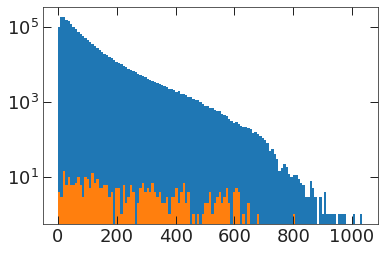

In [32]:
_, bins, _ = plt.hist(allvisit['SNR'][np.isfinite(allvisit['SNR'])], 
                      bins=np.linspace(0, 1035, 128));
plt.hist(visits['SNR'], bins=bins)
plt.yscale('log')

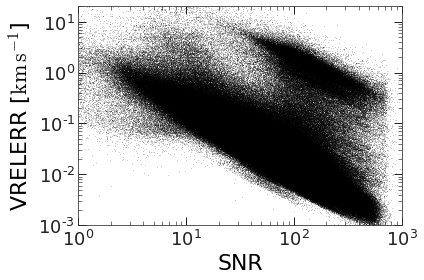

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(allvisit['SNR'], allvisit['VRELERR'], 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('SNR')
ax.set_ylabel('VRELERR [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/calib-err-snr.pdf', dpi=250)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


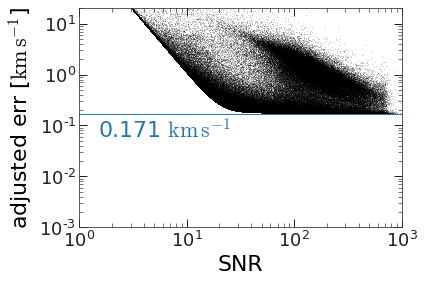

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

new_err = get_new_err(fit, allvisit)
ax.plot(allvisit['SNR'], new_err, 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()

ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.axhline(fit['s'], color='tab:blue', marker='', lw=1)
ax.text(1.5, 0.8*fit['s'], '{:.3f} {:latex_inline}'.format(fit['s'], u.km/u.s), 
        va='top', color='tab:blue', fontsize=22)

ax.set_xlabel('SNR')
ax.set_ylabel('adjusted err [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/calib-adj-err-snr.pdf', dpi=250)

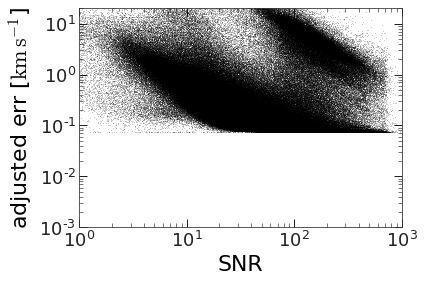

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

nid_err = get_nidever_err(allvisit)
ax.plot(allvisit['SNR'], nid_err, 
        marker=',', color='k', alpha=0.2, ls='none',
        rasterized=True)
fig.tight_layout()

ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-3, 2e1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('SNR')
ax.set_ylabel('adjusted err [{:latex_inline}]'.format(u.km/u.s))

fig.tight_layout()

fig.savefig('calibrate-visit-err/nidever-adj-err.pdf', dpi=250)

---

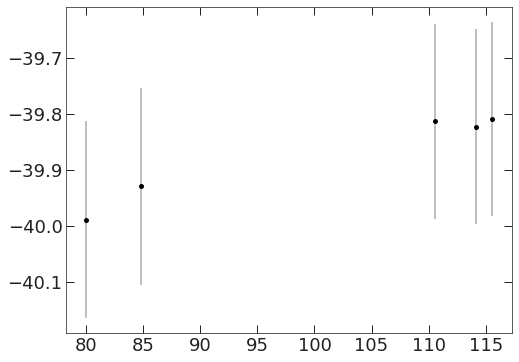

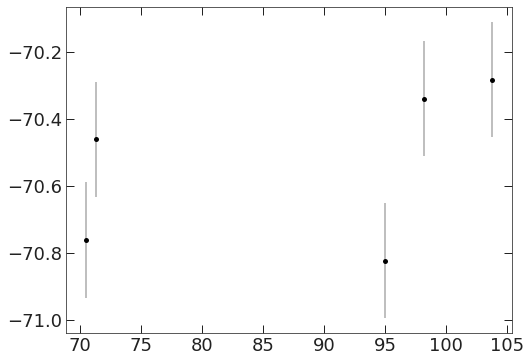

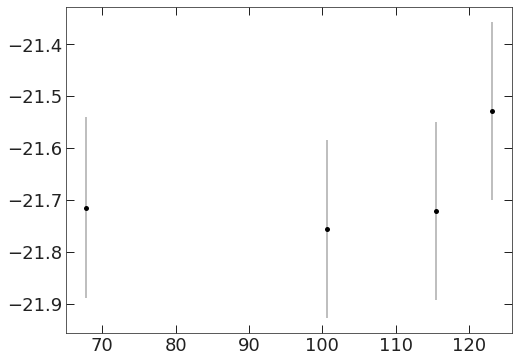

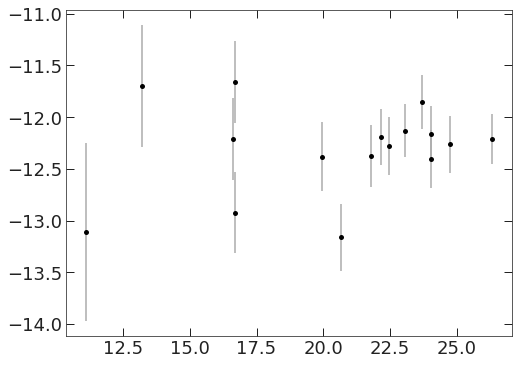

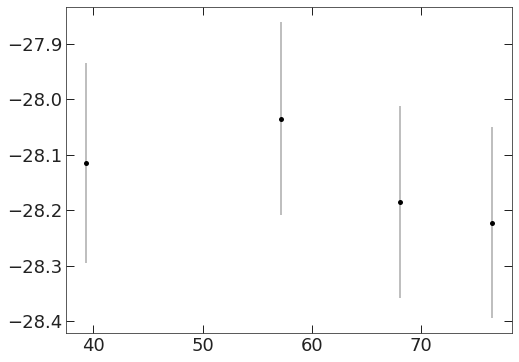

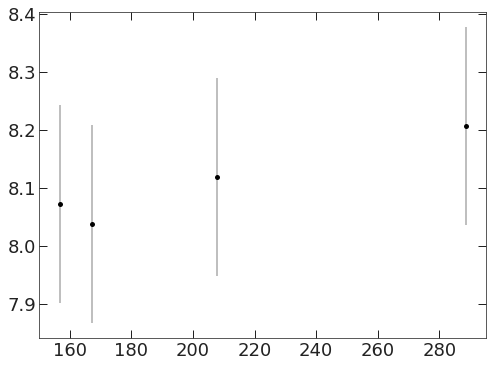

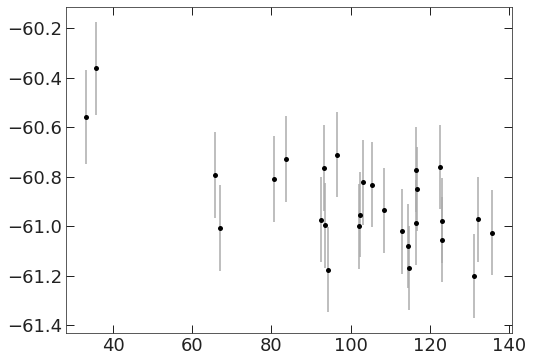

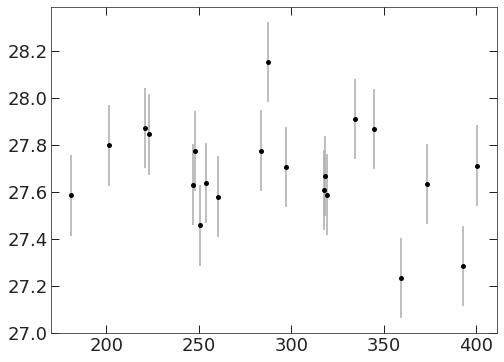

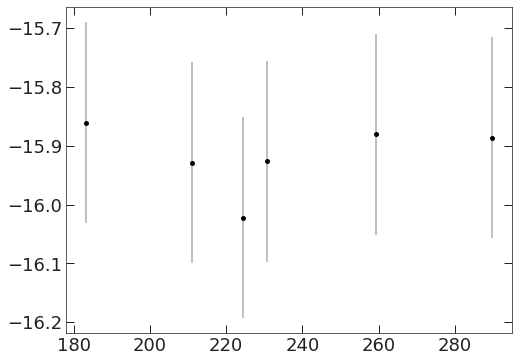

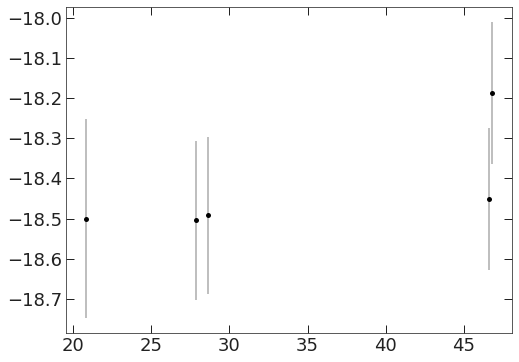

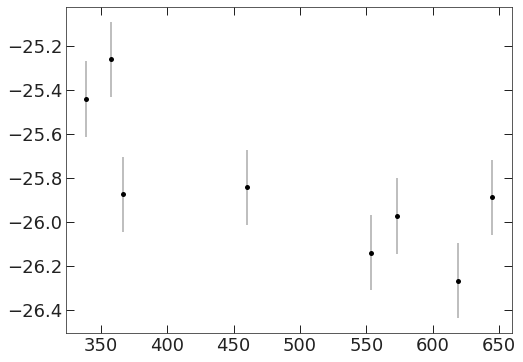

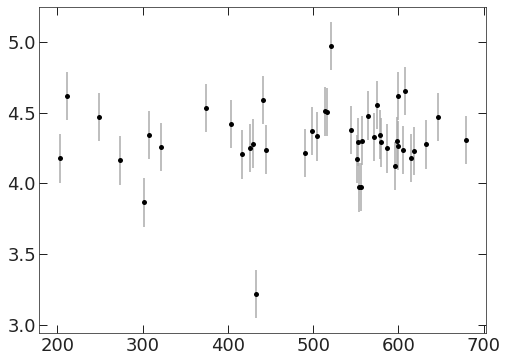

In [40]:
for id_ in apogee_ids[20:]:
    this_visits = visits[(visits['APOGEE_ID'] == id_) & np.isfinite(visits['VHELIO'])]
    
    snr = this_visits['SNR']
    infl_err = get_new_err(fit, this_visits)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.errorbar(snr, this_visits['VHELIO'], infl_err,
                marker='', ecolor='#aaaaaa', zorder=-100, ls='none')
    ax.plot(snr, this_visits['VHELIO'],
            marker='o', ls='none', color='k')